<a href="https://colab.research.google.com/github/catiR/aligned-reaper/blob/main/prosody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prosody tracks for Samrómur Queries

### See the pitch and intensity (root mean squared energy) for speech recordings.

---

How to use:  
Press the arrow in a circle at each code box.  
Wait for it to finish before moving to the next one.  
If you change a value like `min_recordings` or `sent_choice`, click the arrow above it to update.  
Tell caitlinr@ru.is about problems.


In [ ]:
#@title 1. Load the data
#@markdown This may take a minute as there is a large amount of audio

#@markdown TODO: document where the data came from

!git clone https://github.com/catiR/aligned-reaper.git

In [2]:
#@title 2. Set up

%matplotlib agg

import glob, librosa
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from time import sleep
from IPython import display

align_files = glob.glob('aligned-reaper/aligns/*.csv')


# get a whole sentence as a string
def get_whole_sent(alignments):
  return ' '.join([l for l,s,e in alignments])


# for a .csv alignment file from the Montreal Forced Aligner:
#   read the word alignments to a list of (label, start_time, end_time)
#   read in the corresponding pitch data
# and output the alignment + pitch data 
#   with informtion on the speaker and sentence
def compile_all_info(align_file):
  file_id = align_file[:-4].replace('aligned-reaper/aligns/','')
  f0_file = 'aligned-reaper/f0/'+file_id+'.f0'
  with open(align_file,'r') as handle:
    # (there could be problems if MFA doesn't sanitise commas from words/phones)
    align_data = [l.split(',') for l in handle.read().splitlines()]
  align_data = [(l[2],float(l[0]),float(l[1])) for l in align_data if l[3] == 'words']
  sentence = get_whole_sent(align_data)
  with open(f0_file,'r') as handle:
    f0_data = handle.read().split('EST_Header_End\n')[1].splitlines()
  f0_data = [ [float(x) for x in l.split(' ')] for l in f0_data]
  return sentence, file_id, align_data, f0_data

# build a dictionary of data for the sentences
#   for each sentence, the entries are a list of tuples
#   (file_id, align_data, f0_data)
#      for all recordings of that sentence
sentences_data = defaultdict(list) 
for a_f in align_files:
  s, f_id, a_dat, f0_dat = compile_all_info(a_f)
  sentences_data[s].append((f_id,a_dat,f0_dat))


In [ ]:
#@title 3. Show sentence options

#@markdown There are 8534 unique sentences, 
#@markdown with 11902 recordings total. 
#@markdown Only 615 sentences have at least 3 different recordings to compare.

#@markdown Choose the minimum number of recordings per sentence to see.  
#@markdown Sentences without this many will be filtered out:
min_recordings = 8 #@param {type:"integer"}
##@markdown Choose the maximum number of words per sentence. 
##@markdown Longer sentences will be filtered out:
#max_words = 15 #@param {type:"integer"}


sentences_filtered = {k:v for k,v in sentences_data.items() if len(v)>=min_recordings }
#sentences_filtered = {k:v for k,v in sentences_filtered.items() if \
#        (len(k.split(' '))<= max_words) and (len(k.split(' '))> 3) }

sent_num = 1
wrapper = {}
for k in sorted(list(sentences_filtered.keys())):
  print(f'{sent_num}\t{k}')
  wrapper[sent_num] = k
  sent_num +=1


> Listen to 016095-0779347.wav


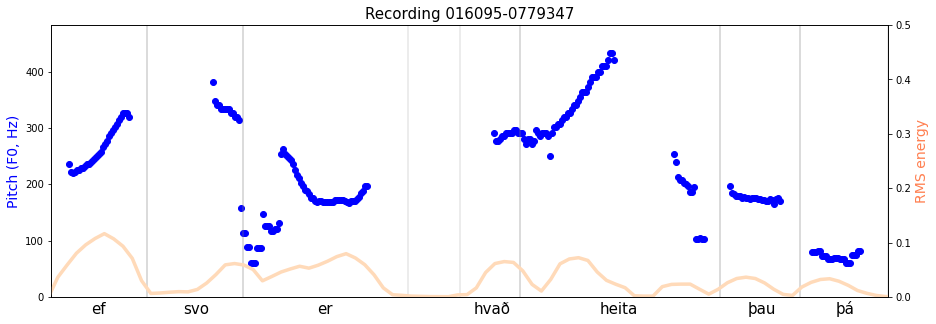




> Listen to 013655-0472136.wav


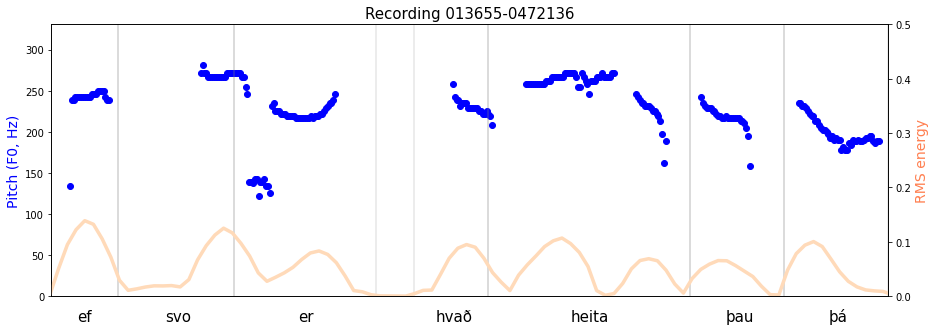




> Listen to 012516-0805497.wav


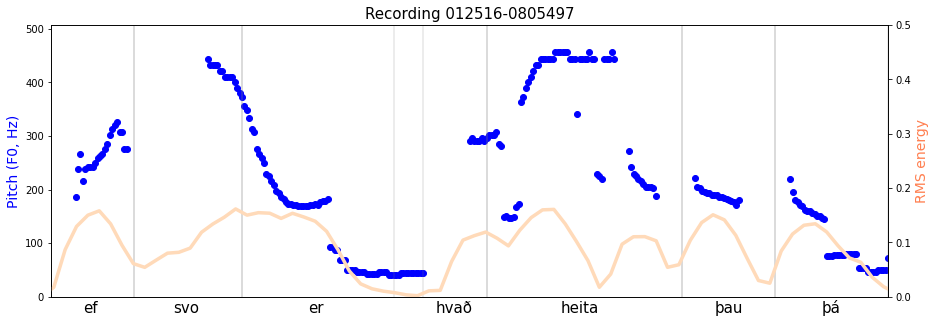




> Listen to 016316-0820122.wav


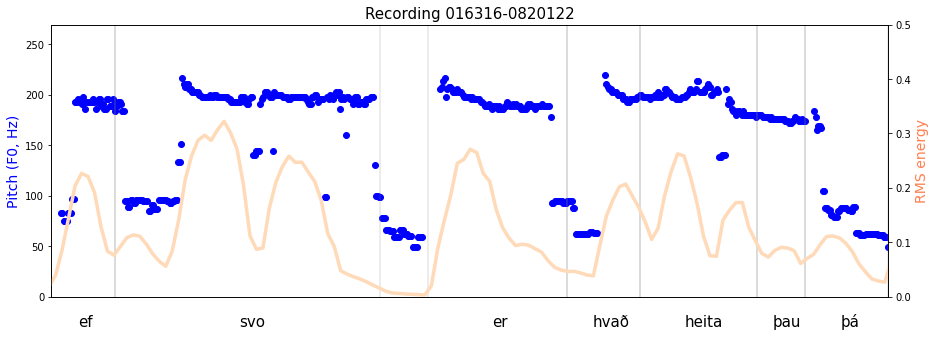




> Listen to 015093-0626953.wav


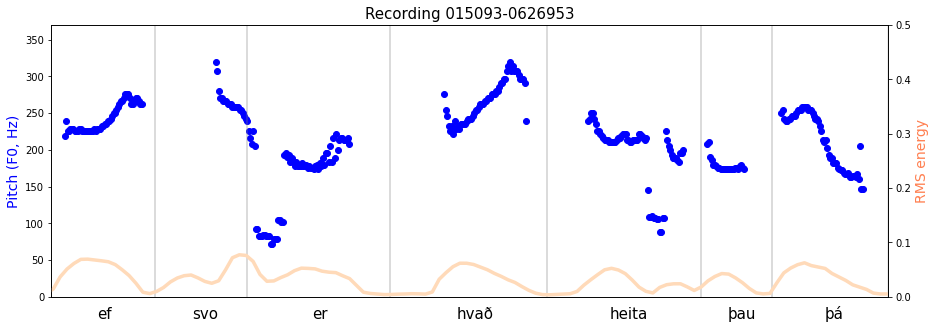




> Listen to 014745-0579621.wav


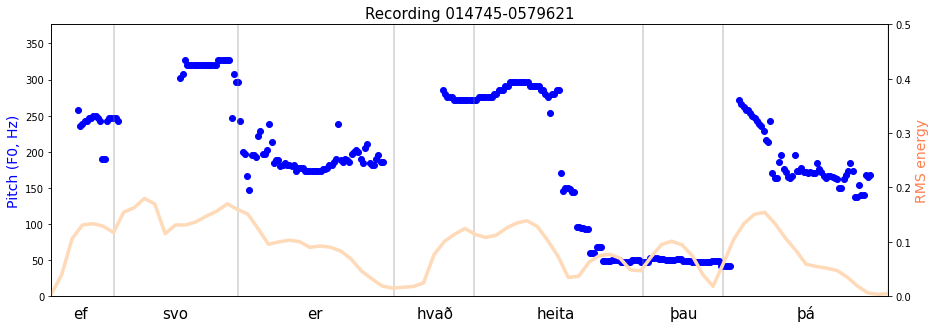




> Listen to 016430-0827018.wav


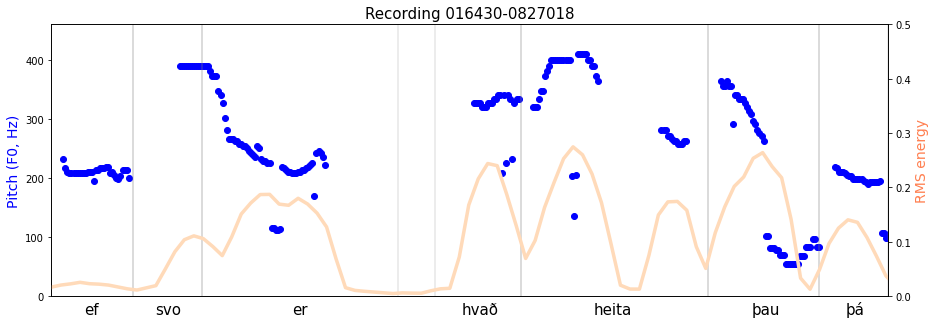




> Listen to 015706-0729370.wav


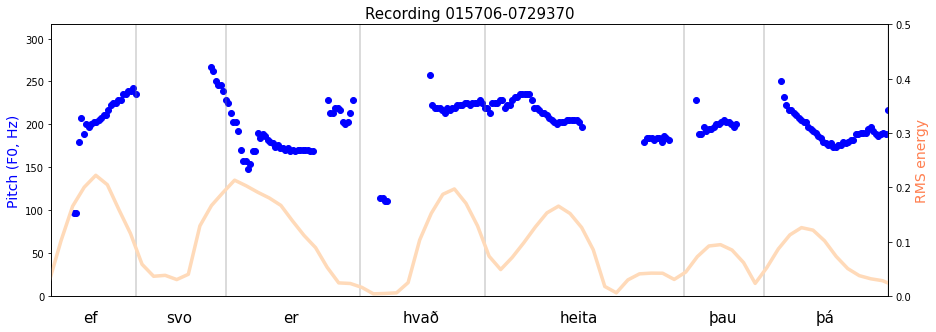




> Listen to 014931-0614721.wav


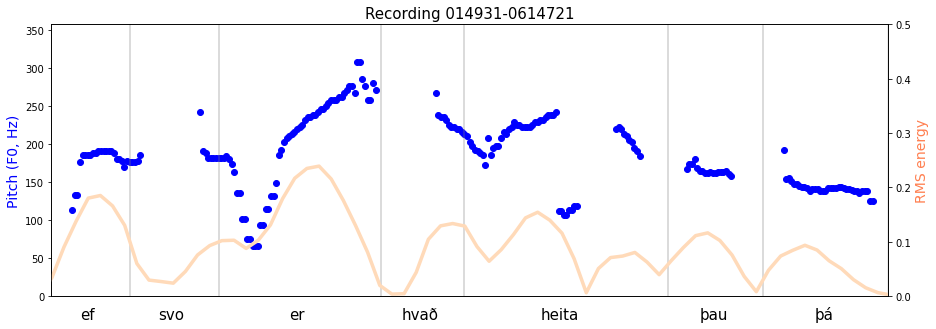

In [19]:
#@title 4. Show prosody tracks for a sentence 

#@markdown Change the number to pick a different sentence, 
#@markdown and click on the arrow again to see the new graphs.

sent_choice = 6 #@param {type:"integer"}


# function to show everything for a single recording
def graph_recording(file_id,align_dat,f0_data):

  # fetch data
  sound_file = f'aligned-reaper/wav/{file_id}.wav'
  f0_data = [[t,f0] for t,prob,f0 in f0_data if prob==1.0]
  f_max = max([f0 for t,f0 in f0_data]) + 50

  # set up the graph shape
  rec_start = align_dat[0][1]
  rec_end = align_dat[-1][2]

  fig, axes1 = plt.subplots(figsize=(15,5))
  plt.xlim([rec_start, rec_end])
  axes1.set_ylim([0.0, f_max])
  axes1.get_xaxis().set_visible(False)

  # draw word boundaries
  for w,s,e in align_dat:
    plt.vlines(s,0,f_max,linewidth=0.3,color='gray')
    plt.vlines(e,0,f_max,linewidth=0.3,color='gray')
    plt.text( (s+e)/2 - (len(w)*.01), -30, w, fontsize=15)

  # show pitch track
  axes1.scatter([t for t,f0 in f0_data], [f0 for t,f0 in f0_data], color="blue")


  # get rms energy
  w, sr = librosa.load(sound_file)
  fr_l = 2048 # librosa default
  h_l = 512 # default
  rmse = librosa.feature.rms(w, frame_length = fr_l, hop_length = h_l)
  rmse = rmse[0]

  # show rms energy
  axes2 = axes1.twinx()
  axes2.set_ylim([0.0, 0.5])
  rms_xval = [(h_l*i)/sr for i in range(len(rmse))]
  axes2.plot(rms_xval,rmse,color='peachpuff',linewidth=3.5)


  # label the graph
  axes1.set_ylabel("Pitch (F0, Hz)", fontsize=14, color="blue")
  axes2.set_ylabel("RMS energy", fontsize=14,color="coral")
  plt.title("Recording "+ file_id, fontsize=15)

  # playable audio above the graph
  print(f'> Listen to {file_id}.wav')
  display.display(display.Audio(sound_file))
  display.display(plt.gcf())
  sleep(0.1)

  

# show all recordings of the selected sentence
sent_datas = sentences_filtered[wrapper[sent_choice]]
plt.close('all')
for rec in sent_datas:
  graph_recording(*rec)
  print('\n\n')


---
**If something is:**
- **interesting**
- **broken**
- **bad audio quality, background noise, or multiple speakers**
- **aligned wrong or has a tracking error**
- **unexpected, such as a child or non-native speaker,**

**please keep a note with the recording number.**  

There are probably some pitch doubling or pitch-halfing errors. See §2.2.2 Ding et al. 2021 *F0 Patterns of L2 English Speech by Mandarin Chinese Learners* to try to fix this.  

---  

comments etc. to caitlinr@ru.is  
https://github.com/catiR/aligned-reaper
